## EXERCISE 4

We want to study the performances of an RBM, and, by looking at its learned weights and biases, better understand the correlations in the data (from file x_RBM_2024_exercise.dat, N=104 configurations with L=10 bits). Use an RBM with M=3 hidden units.

| Name | Surname | ID Number |
|------|---------|---------------------|
| Lucrezia | Rossi | 2122164 |
| Lorenzo | Calandra Buonaura | 2107761 |
| Andrea | Turci | 2106724 |

In [1]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 13

from IPython.display import display_html 
import pandas as pd

In [2]:
dname = "DATA"; fname = dname + '/x_RBM_2024_exercise.dat'

v = np.loadtxt(fname, delimiter = " ", dtype = int)
N = len(v)
L = len(v[1])


print(f'each of N={N} data has L={L} digits')

each of N=10000 data has L=10 digits


In [8]:
class RBM:
    def __init__(self, v, L, M, SPINS = False):
        self.L = L
        self.M = M

        if SPINS:
            self.GAP=2
            self.v = 2 * v - 1
            self.vmin = -1
        else:
            self.GAP=1
            self.vmin = 0
            self.v = v
                    
        self.sigma = np.sqrt(4. / float(L + M))

    def _initialize_weights(self):
        np.random.seed(12345)
        self.w = self.sigma * np.random.randn(self.L, self.M)
        self.a = self.sigma * np.random.randn(self.L)
        self.b = np.zeros(self.M)
        
        self.w0 = np.copy(self.w)
        self.a0 = np.copy(self.a)
        self.b0 = np.copy(self.b)
        
        print("w =", self.w)
        print("a =", self.a)
        print("b =", self.b)
        
    def _energy(self, v, h, a, b, w):
        return -np.dot(v, a) - np.dot(h, b) - np.sum(np.dot(v, w) * h)
    
    def _log_likelihood(self, data, a, b, w):
        possible_configs_v = list(it.product([0, 1], repeat=self.L))
        possible_configs_h = list(it.product([0, 1], repeat=self.M))
        energies = []
        
        for v in data:
            num = np.sum([self._energy(v, h, a, b, w) * np.exp(-self._energy(v, h, a, b, w)) for h in possible_configs_h])
            den = np.sum([np.exp(-self._energy(v, h, a, b, w)) for h in possible_configs_h])
            
            energies.append(num/den)
        
        avg_energy_data = np.mean(energies)
        partition_func = np.sum([np.exp(-self._energy(v, h, a, b, w)) for h in possible_configs_h for v in possible_configs_v])
        
        log_likelihood = - avg_energy_data - np.log(partition_func)
        
        return log_likelihood

    def _activate(self, v_in, wei, bias, DeltaE, info=False):
        
        act = np.dot(v_in, wei) + bias
        n = np.shape(act)
        prob = 1. / (1. + np.exp(-DeltaE*act))
        v_out = np.full(n, self.vmin, dtype=int) # a list on -1's or 0's
        v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
        if info:
            print('input=', v_in)
            print('act=',act)
            print('prob=',prob)
            print('output=',v_out)
        return v_out

    def _compute_cd_steps(self, cd_steps, h_i):
        hf=h_i  #set for the sake of the loop
        for _ in range(cd_steps):
            vf = self._activate(hf,self.w.T,self.a,self.GAP)
            hf = self._activate(vf,self.w,self.b,self.GAP)
        return vf,hf
    
    def _train(self, l_rate=1.0, minibatch_size=500, n_epochs=100, n_steps=1, show_graph = False):
      N = len(self.v)
      np.random.seed(12345)
      np.random.shuffle(self.v)
      log_likelihoods_list = []
      mini, m = minibatch_size, 0
      
      for epoch in range(n_epochs):
        l_rate_epoch = l_rate / mini
        
        for k in range(N):
          if m == 0:
            self._initialize_minibatch()

          h = self._activate(self.v[k], self.w, self.b, self.GAP)
              
          vf, hf = self._compute_cd_steps(n_steps, h)
          self.v_data += self.v[k]
          self.v_model += vf
          self.h_data += h
          self.h_model += hf
          self.vh_data += np.outer(self.v[k].T, h)
          self.vh_model += np.outer(vf.T, hf)
          m += 1

          if m == mini:
            dw = l_rate_epoch * (self.vh_data - self.vh_model)
            da = l_rate_epoch * (self.v_data - self.v_model)
            db = l_rate_epoch * (self.h_data - self.h_model)
            
            if epoch<=1 and k<=mini:
              print('----------- epoch =',epoch,'  k=',k,'  m=',m)
              print('dw =',dw)
              print('da =',da)
              print('db =',db)
                  
            self.w += dw
            self.a += da
            self.b += db
            
            m = 0
                    
        np.random.shuffle(self.v)
        l_rate = l_rate / (0.01 * l_rate + 1)
        ll = self._log_likelihood(self.v, self.a, self.b, self.w)
        log_likelihoods_list.append(ll)
        
        if epoch%10 == 9:
          print(f"Epoch: {epoch+1}, loglikelihood: {ll}")
          
          if show_graph == True:
            self._plot_graph(epoch + 1)
            
      self._plot_log_likelihood(log_likelihoods_list)

    def _initialize_minibatch(self):
        self.v_data = np.zeros(self.L)
        self.v_model = np.zeros(self.L)
        self.h_data = np.zeros(self.M)
        self.h_model = np.zeros(self.M)
        self.vh_data = np.zeros((self.L, self.M))
        self.vh_model = np.zeros((self.L, self.M))
        
    def _plot_log_likelihood(self, log_likelihoods):
      plt.plot(range(len(log_likelihoods)), log_likelihoods)
      plt.xlabel('Epoch')
      plt.ylabel('Log Likelihood')
      plt.title('Log Likelihood vs. Epoch')
      plt.grid(True)
      plt.show()

    def _plot_graph(self, epoch=0):
        fig, ax = plt.subplots(1, 1, figsize=(7, 3.3))
        ax.tick_params(left=False, bottom=False)
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        ax.yaxis.set_major_formatter(plt.NullFormatter())

        x1 = [0] * self.L
        y1 = list(range(self.L))
        for i in range(self.L):
            y1[i] = 1 * (y1[i] / (self.L - 1.) - 0.5)
            
        x2 = [1] * self.L
        y2 = list(range(self.L))
        for i in range(self.L):
            y2[i] = 0.7 * (y2[i] / (self.L - 1.) - 0.5)
            
        A = 1. / max(self.w.max(), -self.w.min())
        for i in range(self.L):
            for j in range(self.M):
                ex, ey, col = (y1[i], y2[j]), (x1[i], x2[j]), self._my_color(self.w[i][j])
                ax.plot(ex, ey, col, zorder=1, alpha=A * abs(self.w[i][j]))

        A = 300.
        for i in range(self.L):
            ax.scatter(y1[i], x1[i], s=A * abs(self.a[i]), zorder=2, c=self._my_color(self.a[i]))

        for j in range(self.M):
            ax.scatter(y2[j], x2[j], s=min(300, A * abs(self.b[j])), zorder=2, c=self._my_color(self.b[j]),
                       marker="s")
        ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
        ax.text(-0.51, 0.85, "hidden\nlayer")
        plt.show()
          
    def noise_reduction(self, n_steps):
      N = len(self.v)
      np.random.seed(12345)
      np.random.shuffle(self.v)
      self.m = 0

      ampl=40
      N1=12

      # original, non-reshuffled data in v0
      v1 = np.zeros_like(self.v)
      for k in range(N):
          h = self._activate(self.v[k], self.w, self.b, self.GAP)
          v1[k], hf = self._compute_cd_steps(n_steps, h)

      # difference between fantasy and data
      diff = (v1 - self.v)/2
      str0 = fname+'_M'+str(self.M)+'-mini'+ str(500)
      np.savetxt(str0+".fantasy", (v1+1)/2, fmt='%d',delimiter=' ')  
      np.savetxt(str0+'.diff', diff, fmt='%d',delimiter=' ')  

      df0 = pd.DataFrame(self.v[:N1])
      df1 = pd.DataFrame(((v1[:N1]- self.vmin)/(1 - self.vmin)).astype(int))

      df0s = df0.style.set_table_attributes("style='display:inline'")
      df1s = df1.style.set_table_attributes("style='display:inline'")
      df0s.map(self.is_one)
      df1s.map(self.is_one)
      sty = [dict(selector="caption",props=[("font-size", "150%")])]
      df0s.set_caption('Original').set_table_styles(sty)
      df1s.set_caption('Denoised').set_table_styles(sty)

      display_html(df0s._repr_html_()+df1s._repr_html_(), raw=True)
      
    @staticmethod
    def _my_color(val):
        if val > 0:
            return 'red'
        elif val < 0:
            return 'blue'
        else:
            return 'black'
          
    @staticmethod
    def is_one(cell_value):
      color0 = 'background-color: gray; color: white'
      color1 = 'background-color: white;'
      if type(cell_value) in [float, int]:
          if cell_value == 1:
              return color1
      return color0

### 1\. & 2\.

- Increase the number of contrastive divergence steps from n=1 to n=5.

- Compute the log-likelihood L  during the training, at every epoch, or every minibatch update if it reaches a maximum already in the first epoch. Use “t” as an index of this “time”, indicating the unit in the figures

w = [[-1.13551379e-01  2.65669964e-01 -2.88132757e-01]
 [-3.08263709e-01  1.09041887e+00  7.72922489e-01]
 [ 5.15360175e-02  1.56284646e-01  4.26576969e-01]
 [ 6.91397593e-01  5.58688134e-01 -7.19014104e-01]
 [ 1.52537913e-01  1.26978019e-01  7.50463234e-01]
 [ 4.91702529e-01 -1.11030861e+00 -2.06261128e-01]
 [ 9.25808667e-01 -2.43274719e-01 -2.99394686e-01]
 [ 2.64583679e-01  1.80218983e+00 -5.66475108e-01]
 [-3.20110440e-01  6.88500960e-02  1.67859802e-01]
 [ 2.90536469e-01  5.21572266e-04  7.45411556e-01]]
a = [-0.39580299 -0.46104103 -1.31476796 -1.03216437 -0.4774623   0.3107127
 -0.70221411  0.06646813 -0.58993056  0.18465011]
b = [0. 0. 0.]
----------- epoch = 0   k= 499   m= 500
dw = [[ 0.046  0.036  0.024]
 [-0.114 -0.152 -0.084]
 [ 0.188  0.18   0.088]
 [ 0.092  0.062  0.052]
 [-0.016 -0.032 -0.01 ]
 [ 0.084  0.04   0.004]
 [ 0.072  0.03  -0.006]
 [-0.196 -0.242 -0.22 ]
 [ 0.088  0.088  0.072]
 [-0.164 -0.132 -0.126]]
da = [ 0.074 -0.13   0.246  0.116 -0.014  0.084  0.086 -0.

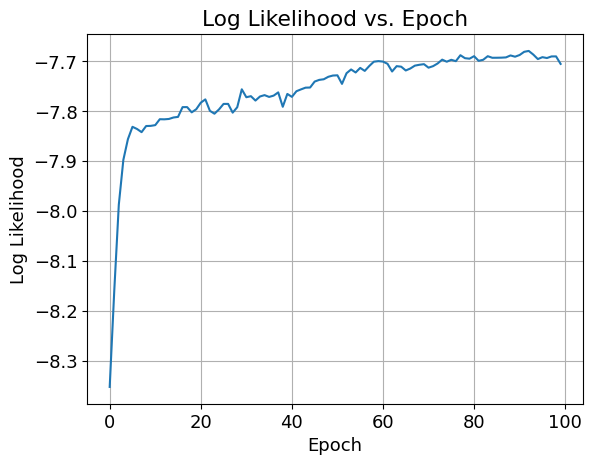

In [9]:
M=3

rbm = RBM(v, L, M)
rbm._initialize_weights()
rbm._train(n_steps = 5, show_graph=True)

### 3\.

Try RBMs with different numbers of hidden units: M=1, 2, 3 (done above), 4, 5, and 6.

In [ ]:
hidden_units = [ 1, 2, 4, 5, 6]

for M in hidden_units:
    print(f"Training RBM with {M} hidden units...")
    rbm = RBM(v, L=L, M=M)
    rbm._initialize_weights()
    rbm._train()

### 4\.
For M=3, plot L as a function of “t”, comparing the two contrastive divergence cases (n=1 and n=5). Then, for n=1, plot L as a function of “t”, comparing the two cases with different M.

In [5]:
steps = [1, 5]

for step in steps:
    print(f"Training RBM with n_step = {step} ...")
    rbm = RBM(v, L=L, M=3)
    rbm._initialize_weights()
    rbm._train(n_steps=step)

AttributeError: 'RBM' object has no attribute 'minibatch_size'

In [ ]:
M_values = [1, 5]

for M in M_values:
    print(f"Training RBM with M = {M} ...")
    rbm = RBM(v, L=L, M=M)
    rbm._initialize_weights()
    rbm._train()

### 5\.

Several significant observations emerge regarding the data structure and the effectiveness of RBM in learning them:

- Structure of connections between hidden layers and visible data: for n_steps=5, we can observe that for M=1 and M=2, the hidden layers have very weak or almost transparent connections with the visible data, suggesting a low correlation. However, for M=3, a stronger connection with a single hidden layer is observed, indicating increased interaction between the data and the hidden layers. As M increases beyond 3, the connections become more chaotic and less distinct.

- Trend of log-likelihood in relation to n_steps: it's clear that the log-likelihood for n_steps=1 is slightly higher than n_steps=5 for M=3. Both log-likelihoods show an increase with increasing epochs, indicating convergence of the model towards an optimal data representation. However, the difference in log-likelihood suggests that n_steps=1 might converge more rapidly or may be more suitable for this particular dataset.

- Effect of the number of hidden layers on log-likelihood: For n_steps=1, it is observed that the log-likelihood for M=1 increases rapidly initially and remains relatively constant, suggesting that a single hidden layer is sufficient to capture the relationships in the data. However, for M=4, the log-likelihood starts from a lower value and shows a gradual increase, indicating that a greater number of hidden layers may be necessary to model the complexity of the data more accurately.

In summary, the data indicates that the data structure may be better represented by a model with a moderate number of hidden layers (M=3) and with a low number of contrastive divergence steps (n_steps=1), which shows rapid improvement in log-likelihood and greater stability over time. These observations suggest that the RBM model is effectively capturing relationships in the data and converging towards an optimal representation.

In [12]:
rbm.noise_reduction(1)

AttributeError: 'RBM' object has no attribute 'minibatch_size'